In [6]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helper

ticker = ['NVDA', 'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'AVGO', 'BRK-B', 'WMT']  # Top-10 S&P 500
reference = ['VOO']
past = '3y'  # 3 years of historical data

df = helper.read_ticker(ticker, past)
df_ref = helper.read_ticker(reference, past)
df_ref.head()
weights = [1/len(ticker) for _ in ticker]
for i, t in enumerate(ticker):
    df[f'Returns_{t}'] = df[f'{t}_Close'].pct_change().fillna(0)
df['Returns_eq'] = np.sum([df[f'Returns_{t}'] * weights[i] for i, t in enumerate(ticker)], axis=0)
df['Returns_ref'] = df_ref[f'{reference[0]}_Close'].pct_change().fillna(0)

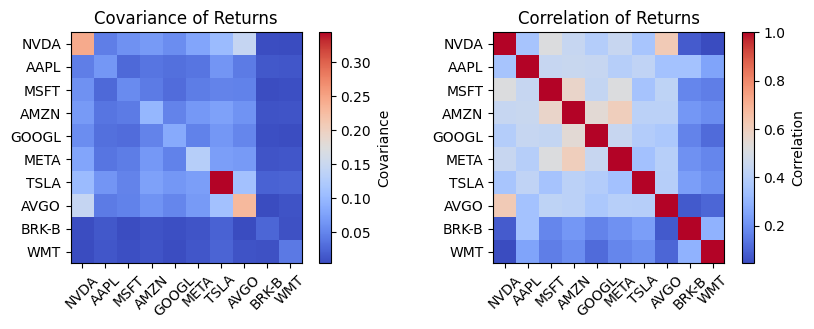

In [8]:
df_returns = df[[f'Returns_{t}' for t in ticker]]

# Covariance matrix. Shows direction of evolution, but can be hard to interpret due to scale.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
im = ax1.imshow(df_returns.cov() * 252, cmap='coolwarm')
fig.colorbar(mappable=im, ax=ax1, label='Covariance')
ax1.set_xticks(ticks=range(len(ticker)), labels=ticker, rotation=45)
ax1.set_yticks(ticks=range(len(ticker)), labels=ticker)
ax1.set_title('Covariance of Returns')

# Normalized correlation. Direct indicator of how returns move together, independent of scale
im = ax2.imshow(df_returns.corr(), cmap='coolwarm')
fig.colorbar(mappable=im, ax=ax2, label='Correlation')
ax2.set_xticks(ticks=range(len(ticker)), labels=ticker, rotation=45)
ax2.set_yticks(ticks=range(len(ticker)), labels=ticker)
ax2.set_title('Correlation of Returns')
plt.show()

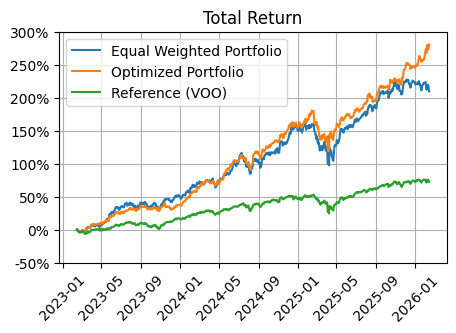

In [9]:
import scipy.optimize
df['FED_rate'], _ = helper.read_risk_free()


# Evaluate sharpe ration of portfolio
def eval_portfolio(df: pd.DataFrame, weights: list[float]) -> tuple[float, float]:
  df['Returns'] = np.sum([df[f'Returns_{t}'] * weights[i] for i, t in enumerate(ticker)], axis=0)
  sharpe = helper.sharpe_ratio(df['Returns'], df['FED_rate'])
  return sharpe


# Function to minimize
def negative_sharpe_ratio(weights: list[float], df: pd.DataFrame):
  sharpe = eval_portfolio(df, weights)
  return -sharpe


# Find weights for optimal sharpe ratio
res = scipy.optimize.minimize(negative_sharpe_ratio, x0=weights, args=(df), bounds=[(0, 1) for _ in ticker], constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
weights = res.x

df['Returns_weighted'] = np.sum([df[f'Returns_{t}'] * weights[i] for i, t in enumerate(ticker)], axis=0)
df['Value_eq'] = (1 + df['Returns_eq']).cumprod() - 1  # cumulative product to get the growth of $1 invested with equal weights
df['Value_weighted'] = (1 + df['Returns_weighted']).cumprod() - 1  # with calculated weights
df['Value_ref'] = (1 + df['Returns_ref']).cumprod() - 1  # compared to reference

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(df.index, df['Value_eq'], label='Equal Weighted Portfolio')
ax.plot(df.index, df['Value_weighted'], label='Optimized Portfolio')
ax.plot(df.index, df['Value_ref'], label=f'Reference ({reference[0]})')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Total Return')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{y * 100:.0f}%' for y in ax.get_yticks()])
ax.legend()
ax.grid()
plt.show()

In [10]:
# portfolio_vola = np.sqrt(weights @ cov_matrix @ weights)  # alternative formula for portfolio volatility
print(f'Time Period: {past}')
print(f'Total return: {df['Value_weighted'].iloc[-1] * 100:.2f}%, (equal weights: {df['Value_eq'].iloc[-1] * 100:.2f}%)')
print(f'Total Sharpe ratio: {-res.fun:.3f} (equal weights: {helper.sharpe_ratio(df[f'Returns_eq'], df['FED_rate']):.3f})')
print(f'Total Volatility: {df['Returns_weighted'].std() * np.sqrt(252):.3f} (equal weights: {df['Returns_eq'].std() * np.sqrt(252):.3f})')
print('Allocation\tSharpe\tVola.')
for i, t in enumerate(ticker):
  print(f'{t}: {res.x[i]:.2%}\t{helper.sharpe_ratio(df[f'Returns_{t}'], df['FED_rate']):.3f}\t{df[f'Returns_{t}'].std() * np.sqrt(252):.3f}')

Time Period: 3y
Total return: 278.65%, (equal weights: 209.52%)
Total Sharpe ratio: 2.292 (equal weights: 1.555)
Total Volatility: 0.181 (equal weights: 0.225)
Allocation	Sharpe	Vola.
NVDA: 17.29%	1.583	0.494
AAPL: 0.00%	0.607	0.257
MSFT: 0.00%	0.484	0.236
AMZN: 0.00%	0.742	0.312
GOOGL: 14.05%	1.287	0.291
META: 3.27%	1.246	0.361
TSLA: 0.00%	0.531	0.586
AVGO: 4.21%	1.327	0.478
BRK-B: 6.67%	0.770	0.157
WMT: 54.50%	1.603	0.203
